# Машинное обучение, DS-поток, осень 2022
## Задание 3.11


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

В задании требуется вывести формулы для обратного прохода.
* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов

**Баллы за задание**  
    1. Простая нейронная сеть &mdash; **40 баллов**  
    2. BatchNorm &mdash; **60 баллов**  
    3. Dropout &mdash; **40 баллов**  
    4. Регуляризаци весоав &mdash; **30 баллов**  
    5. Затухание градиента &mdash; **30 баллов**  
    6. Выводы &mdash; **10 баллов**  
    
 Всего &mdash;   **210 баллов**.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4, palette='Set2')
import numpy as np

from torchvision.datasets import FashionMNIST

import torch
from torch import nn
from torch.utils.data import DataLoader

from collections import defaultdict
import time

from IPython.display import clear_output

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'


В данном задании вам предстоит проверить на практике эффективность методов, представленных на лекции на одном из базовых датасетов для нейронных сетей. Естественно, обобщать наблюдения нельзя, но некоторые тенденции вы сможете заметить.

**Совет**

Это задание будет быстрее выполнить на GPU. Чтобы не тратить много времени на GPU (важно на Google Colab), **проверяйте работоспособность кода на CPU на маленьком объеме данных**, где это возможно, а затем переходите на GPU.

### 0. Данные
Будем использовать набор данных **Fasion MNIST**. Скачаем тренировочный и тестовый наборы данных. 

In [3]:
train_source = FashionMNIST('fasionmnist', download=True, train=True)
test_source = FashionMNIST('fasionmnist', download=True, train=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fasionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fasionmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fasionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fasionmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fasionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fasionmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fasionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fasionmnist/FashionMNIST/raw



Он содержит 60 000 изображений в тренировочной части данных и 10 000 в тестовой.

In [4]:
len(train_source.data), len(test_source.data)

(60000, 10000)

В датасете содержится 10 классов одежды.

In [5]:
train_source.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Можно посмотреть их названия.

In [6]:
train_source.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Проиллюстрируем набор данных.

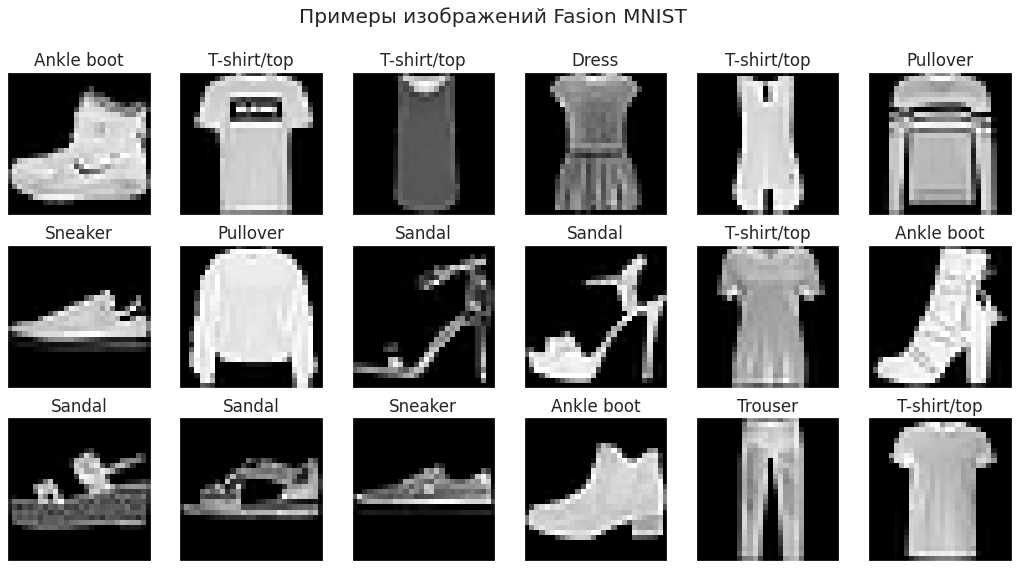

In [7]:
fig, axs = plt.subplots(3, 6, figsize=(18, 9))
for k, (image, label) in enumerate(zip(train_source.data[:18], train_source.targets[:18])):
    i, j = k // 6, k % 6
    axs[i][j].imshow(image, cmap='gray')
    axs[i][j].grid(b=None)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].set_title(train_source.classes[label])
fig.suptitle('Примеры изображений Fasion MNIST')
plt.show()

In [8]:
train_source.data[0].shape

torch.Size([28, 28])

### 1. Простая полносвязная нейронная сеть

Постройте простую полносвязную двухслойную нейронную сеть с функцией активации ReLU. Обучите ее на тренировочной части данных. Используйте кроссэнтропию в качестве функции ошибки. Добейтесь хотя бы 0.87 accuracy на тестовой части данных. 

In [9]:
class SimpleDataset():
    """
    Простой итерериуемый датасет.
    """

    def __init__(self, X_data, y_data):
        assert len(X_data) == len(y_data)
        self.x = X_data
        self.y = y_data

    def __len__(self):
        """
        Размер датасета.
        """

        return len(self.y)

    def __getitem__(self, idx):
        """
        Обращение к элементу датасета по индексу.
        """
        xi = self.x[idx].ravel().to(torch.float32)
        yi = self.y[idx].to(torch.long)
        return xi, yi

In [10]:
batch_size = 64
num_workers = 2

In [11]:
train_dataset = SimpleDataset(train_source.data, train_source.targets)
test_dataset = SimpleDataset(test_source.data, test_source.targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [12]:
def train(
        model, 
        criterion,
        optimizer, 
        train_loader,
        val_loader,
        num_epochs, 
        device,
        checkpoint_path='nn_1',
):
    """
    # Обучение модели
    """

    start_time = time.time()

    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.

    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()
            train_acc += (y_batch == y_pred).sum()
            train_size += len(y_batch)

        # Подсчитываем лоссы и точность, сохраням в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_acc = train_acc.cpu().numpy() / train_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.detach() * len(y_batch)
                y_pred = torch.argmax(logits, axis=1).detach()
                val_acc += (y_batch == y_pred).sum()
                val_size += len(y_batch)
        
        #model.train()

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss = val_loss.cpu().numpy() / val_size
        val_acc = val_acc.cpu().numpy() / val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # Сохраняем лучшую модель по метрике на валидации
        if (val_acc > best_val_acc):
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)
            best_val_acc = val_acc
            
        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {}. Total time {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

In [13]:
model = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [15]:
history_1 = train(
    model, 
    criterion,
    optimizer, 
    train_loader,
    test_loader,
    num_epochs=25, 
    device=device,
    checkpoint_path='nn_1',
)

Epoch 25 of 25. Total time 106.577s
  training loss (in-iteration): 	0.176412
  validation loss (in-iteration): 	0.408078
  training accuracy: 			93.40 %
  validation accuracy: 			88.12 %


Accuracy на валидации получилась 0.88 как и требовалось.

Визуализируйте "вероятности" предскаазнных моделью классов для нескольких изображений из теста.

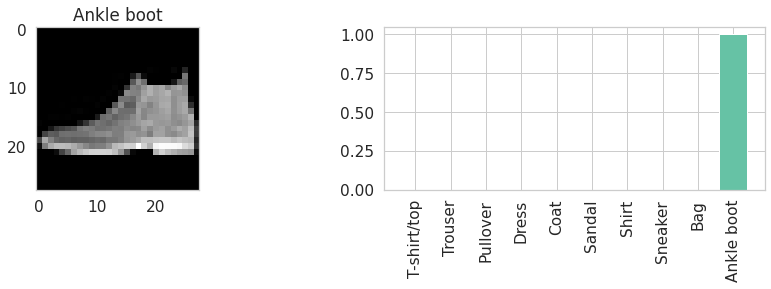

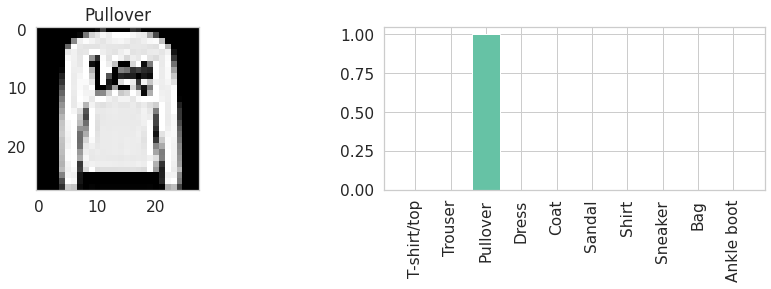

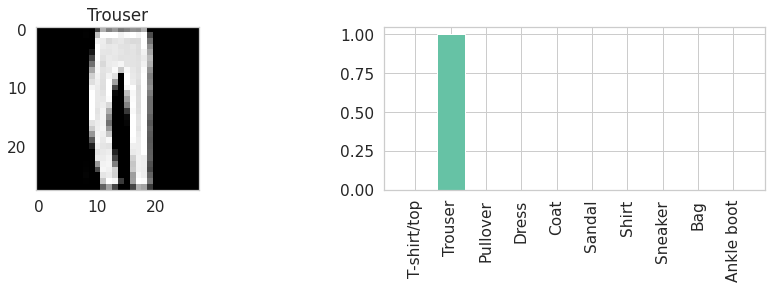

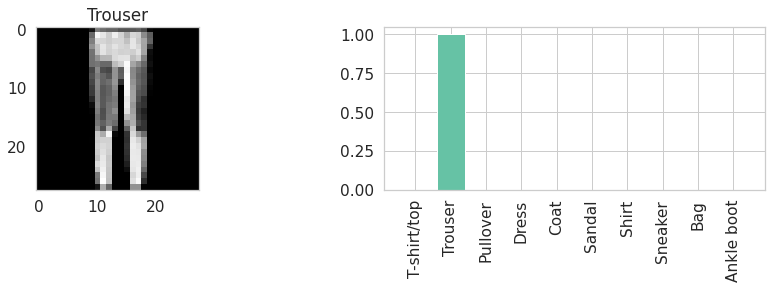

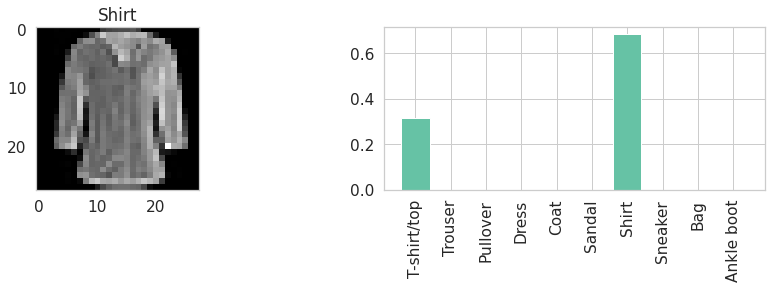

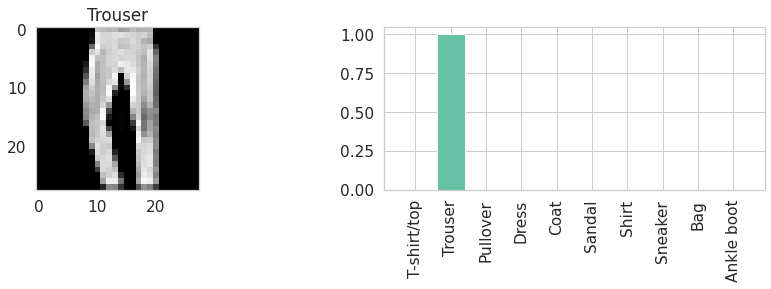

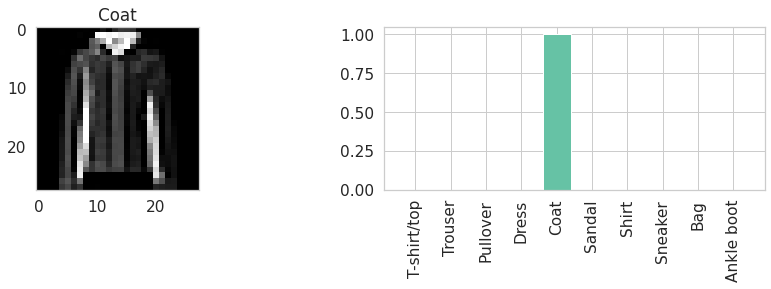

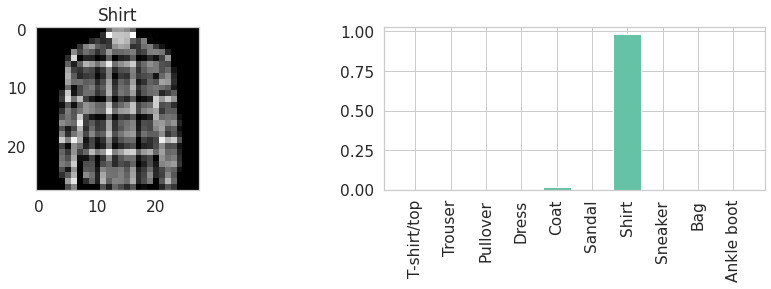

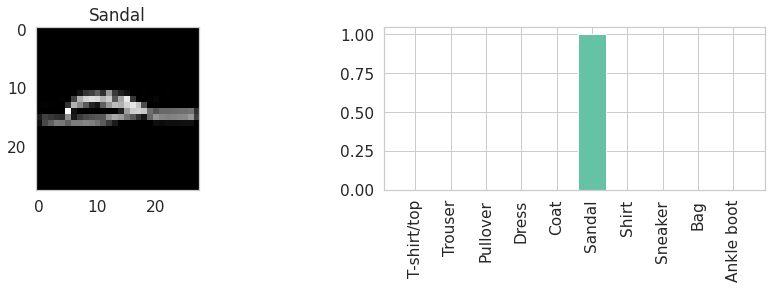

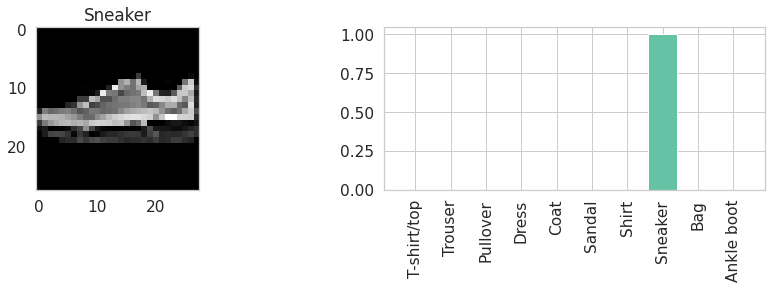

In [16]:
for i in range(10):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(15, 3))
        image, target = test_dataset[i]

        plt.subplot(1, 2, 1)
        plt.grid(b=None)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.title(test_source.classes[target.item()])

        plt.subplot(1, 2, 2)
        with torch.no_grad():
            logits = model(image.to(device).unsqueeze(0))[0].cpu()
        probabilitys = torch.softmax(logits, dim=0)
        plt.bar(test_source.classes, probabilitys)
        plt.xticks(rotation=90)

Видно, что почти во всех случаях вероятность модели получить верный ответ равна 1, только в одном случае веротяность немного меньше.

### 2. BatchNorm

Проверьте два варианта включения BatchNorm в архитектуру двухслойной сети: до функции активации и после нее. В итоге получается 2 модели:
```
(1) Linear -> BatchNorm -> ReLU -> Linear
(2) Linear -> ReLU -> BatchNorm -> Linear
```
Обучите обе модели. Постройте графики распределений выходов первого, второго и третьего слоя сети (т.е. всех кроме последнего) для каждой модели до обучения, в процессе обучения и после обучения. Сравните эти графики с соответствующими графиками модели без BatchNorm. 

In [17]:
models = {
    # модель без батч-нормализации
    'no_bn': nn.Sequential(
        nn.Linear(784, 200),
        nn.ReLU(),
        nn.Linear(200, 10),
    ),
    # первый вариант модлеи с батч-нормализацией
    'bn_1': nn.Sequential(
        nn.Linear(784, 200),
        nn.BatchNorm1d(200),
        nn.ReLU(),
        nn.Linear(200, 10),
    ),
    # второй вариант модлеи с батч-нормализацией
    'bn_2': nn.Sequential(
        nn.Linear(784, 200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200, 10),
    ),
}

In [18]:
def calc_outputs(model, device):
    model.to(device)
    outputs1, outputs2, outputs3 = [], [], []
    with torch.no_grad():
        for image, i in train_loader:
            image = image.to(device)
            out1 = model[0](image)
            out2 = model[1](out1)
            out3 = model[2](out2)
            outputs1.append(out1.ravel().cpu())
            outputs2.append(out2.ravel().cpu())
            outputs3.append(out3.ravel().cpu())
    return torch.cat(outputs1), torch.cat(outputs2), torch.cat(outputs3)

In [19]:
outputs = {}
for name in ['no_bn', 'bn_1', 'bn_2']:
    outputs[name] = {'l1': {}, 'l2': {}, 'l3': {}}
outputs

{'no_bn': {'l1': {}, 'l2': {}, 'l3': {}},
 'bn_1': {'l1': {}, 'l2': {}, 'l3': {}},
 'bn_2': {'l1': {}, 'l2': {}, 'l3': {}}}

In [21]:
for model_name, model in models.items():
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=1e-4, 
    )

    # выходы слоев перед обучением
    model_outputs = calc_outputs(model, device)
    outputs[model_name]['l1']['init'] = model_outputs[0]
    outputs[model_name]['l2']['init'] = model_outputs[1]
    outputs[model_name]['l3']['init'] = model_outputs[2]

    train(
        model, 
        criterion,
        optimizer, 
        train_loader,
        test_loader,
        num_epochs=3, 
        device=device,
    )

    # выходы слоев во время обучения после 3 эпох
    model_outputs = calc_outputs(model, device)
    outputs[model_name]['l1']['train'] = model_outputs[0]
    outputs[model_name]['l2']['train'] = model_outputs[1]
    outputs[model_name]['l3']['train'] = model_outputs[2]

    train(
        model, 
        criterion,
        optimizer, 
        train_loader,
        test_loader,
        num_epochs=25, 
        device=device,
    )

    # выходы слоев после обучения модели
    model_outputs = calc_outputs(model, device)
    outputs[model_name]['l1']['final'] = model_outputs[0]
    outputs[model_name]['l2']['final'] = model_outputs[1]
    outputs[model_name]['l3']['final'] = model_outputs[2]

Epoch 25 of 25. Total time 109.119s
  training loss (in-iteration): 	0.177419
  validation loss (in-iteration): 	0.684443
  training accuracy: 			93.62 %
  validation accuracy: 			87.83 %


In [ ]:
model_names = [('no_bn', 'bn_1', 'bn_2'), ('Без BatchNorm', 'BatchNorm до ReLU', 'BatchNorm после ReLU')]

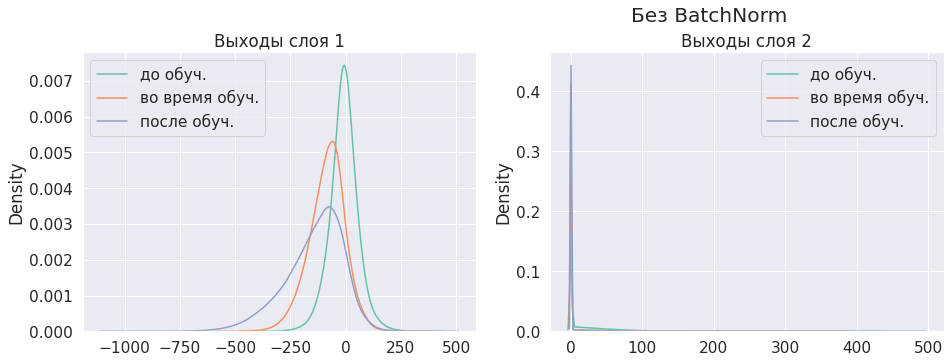

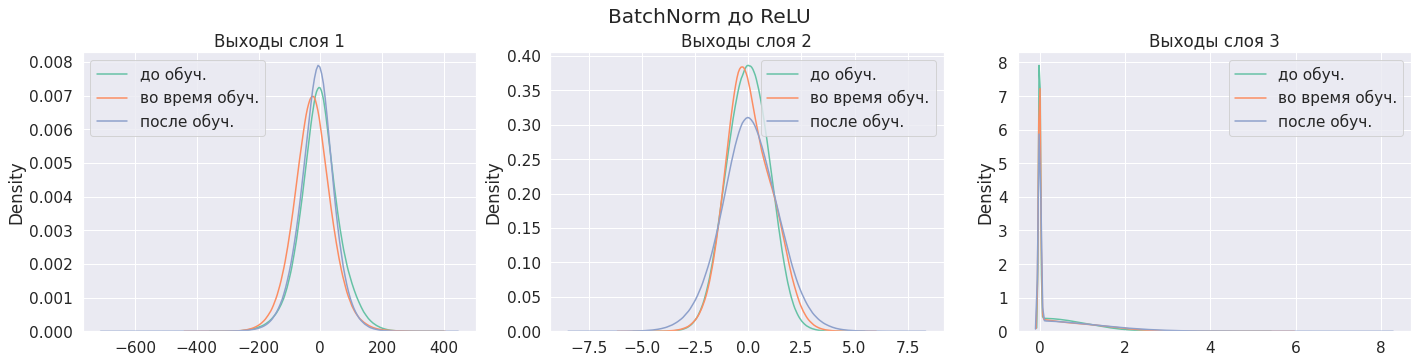

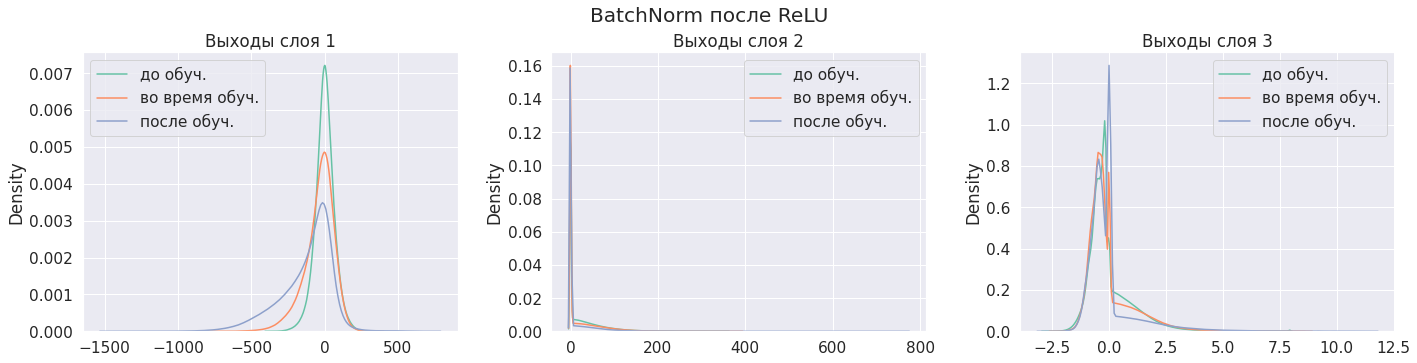

In [23]:
for model_name, model_name_2 in zip(model_names):
    fig = plt.figure(figsize=(20, 5))

    if model_name == 'no_bn':
        n_it = 2
    else:
        n_it = 3
    for i in range(n_it):
        plt.subplot(1, 3, i + 1)
        sns.kdeplot(outputs[model_name][f'l{i + 1}']['init'], label='без обуч.')
        sns.kdeplot(outputs[model_name][f'l{i + 1}']['train'], label='во время обуч.')
        sns.kdeplot(outputs[model_name][f'l{i + 1}']['final'], label='после обуч.')
        plt.title(f'Выходы слоя {i + 1}')
        plt.legend()

    fig.suptitle(model_name_2)
    plt.show()

Из графиков видно, что в случае когда BatchNorm находится до ReLU выходы второго слоя меняются совсем немного. В случае же когда он находится после ReLU выходы второго слоя меняются значительно. Также видно, что без нормализации получается очень большая дисперсия выходов. Если же BatchNorm находится после ReLU, то ситуация будет похожей как и без нормализации (большая дисперсия выходов).

Обучите оба варианта модели с BatchNorm с разными инициализациями хотя бы 3 раза. Инициализации должны отличаться только random state. Сравните качество моделей по loss и accuracy в зависимости от номера итерации.

In [25]:
history = []

In [26]:
for i in range(3):
    model = nn.Sequential(
        nn.Linear(784, 200),
        nn.BatchNorm1d(200),
        nn.ReLU(),
        nn.Linear(200, 10),
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    history.append(train(
                      model, 
                      criterion,
                      optimizer, 
                      train_loader,
                      test_loader,
                      num_epochs=15, 
                      device=device,
                  )
    )

Epoch 15 of 15. Total time 69.379s
  training loss (in-iteration): 	0.212561
  validation loss (in-iteration): 	0.327162
  training accuracy: 			92.61 %
  validation accuracy: 			88.21 %


In [27]:
for i in range(3):
    model = nn.Sequential(
        nn.Linear(784, 200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200, 10),
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    history.append(train(
                    model, 
                    criterion,
                    optimizer, 
                    train_loader,
                    test_loader,
                    num_epochs=15, 
                    device=device,
                )
    )

Epoch 15 of 15. Total time 67.537s
  training loss (in-iteration): 	0.228881
  validation loss (in-iteration): 	0.802399
  training accuracy: 			91.72 %
  validation accuracy: 			87.78 %


In [30]:
def plot_histories(histories, names, colors, legend):
  
    figsize = (20, 8)
    if legend == 0:
        legend = np.arange(len(histories))

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    for i, (history, name) in enumerate(zip(histories, names)):
      train_label = f'обуч. {name}'
      val_label = f'валид. {name}'

      axs[0].set_title('Кроссэнтропия')
      axs[0].plot(history['loss']['train'], label=train_label, color=colors[i], lw=3)
      axs[0].plot(history['loss']['val'], label=val_label, ls='--', color=colors[i], lw=3)
      axs[0].set_xlabel('эпоха')
      axs[0].legend()

      axs[1].set_title('Точность')
      axs[1].plot(history['acc']['train'], label=train_label, color=colors[i], lw=3)
      axs[1].plot(history['acc']['val'], label=val_label, ls='--', color=colors[i], lw=3)
      axs[1].set_xlabel('эпоха')
      axs[1].legend()

In [61]:
colors = sns.color_palette("Set1")

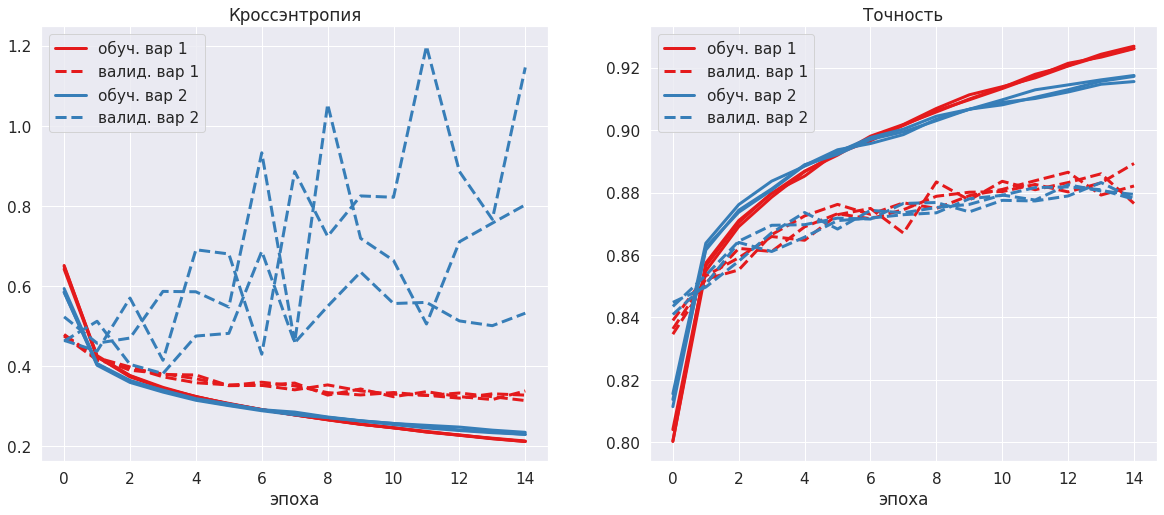

In [35]:
plot_histories(history, names=['вар 1'] * 3 + ['вар 2'] * 3, colors=[colors[0]] * 3 + [colors[1]] * 3, legend=[0, 3])

Из графиков видно, что в целом модель лучше обучается в первом варианте, то есть когда BatchNorm находится до ReLU. В случае когда BatchNorm после ReLU точность модели хуже и кросэнтропия сильно меняется.

Выберите лучшую обученную модель с BatchNorm. Посмотрите на распределение выходов слоя до BatchNorm и самого BatchNorm для нескольких батчей из тестовой части данных. Согласуются ли результаты с утверждением, что BatchNorm решает проблему ковариантного сдвига для батчей?



In [41]:
model = nn.Sequential(
    nn.Linear(784, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train(
    model, 
    criterion,
    optimizer, 
    train_loader,
    test_loader,
    num_epochs=15, 
    device=device,
);

Epoch 15 of 15. Total time 68.200s
  training loss (in-iteration): 	0.209350
  validation loss (in-iteration): 	0.318136
  training accuracy: 			92.80 %
  validation accuracy: 			88.60 %


In [49]:
outputs_1 = []
outputs_2 = []
for i, (image, j) in enumerate(test_loader):
    if i > 3:
        break
    with torch.no_grad():
        out1 = model[0](image.to(device))
        out2 = model[1](out1)
    outputs_1.append(out1.ravel().cpu())
    outputs_2.append(out2.ravel().cpu())

<ipython-input-60-87fb3ccbcf77>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-60-87fb3ccbcf77>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)
<ipython-input-60-87fb3ccbcf77>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and 

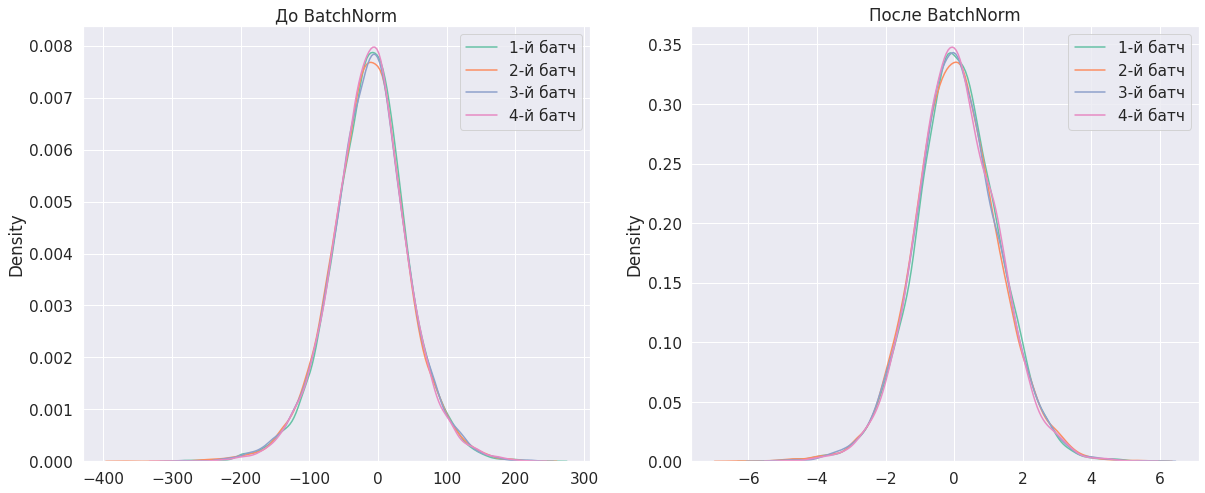

In [60]:
plt.figure(figsize=(20, 8))
for i in range(4):
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=outputs_1[i], label=f'{i + 1}-й батч')
    if i == 0:
        plt.title('До BatchNorm')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=outputs_2[i], label=f'{i + 1}-й батч')
    if i == 0:
        plt.title('После BatchNorm')
    plt.legend()

Из графиков видно, что и до, и после BatchNorm распределения батчей довольно похожие.

### 3. Dropout
Для начала добейтесь переобучения модели. Это можно сделать, если использовать меньше параметров в слое, дольше обучать или поменять параметры оптимизатора.

In [67]:
model_history = []

model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model_history.append(train(
                    model,
                    criterion,
                    optimizer, 
                    train_loader,
                    test_loader,

                    num_epochs=45, 
                    device=device,
                )
)

Epoch 45 of 45. Total time 186.619s
  training loss (in-iteration): 	0.377271
  validation loss (in-iteration): 	0.562452
  training accuracy: 			86.65 %
  validation accuracy: 			83.14 %


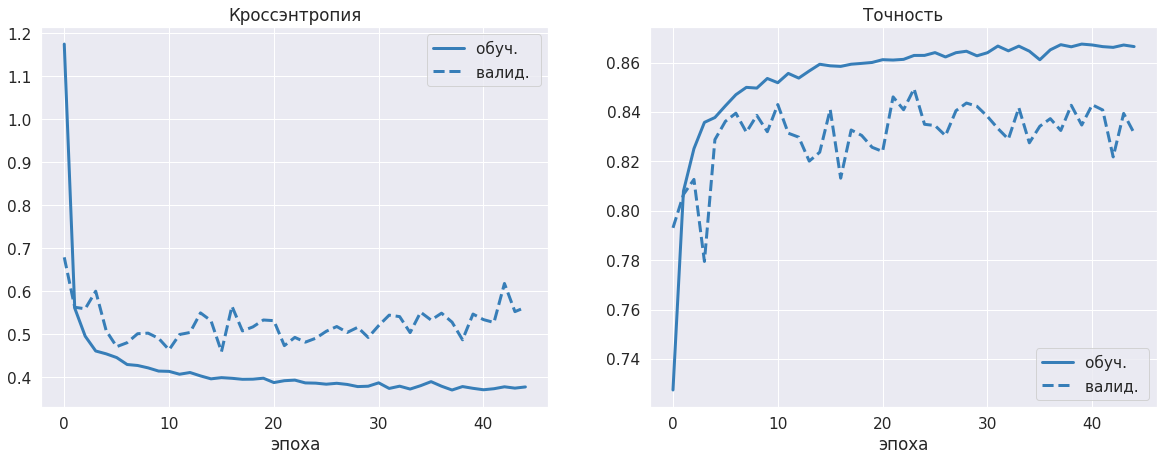

In [68]:
plot_histories(model_history, [''], colors=[colors[1]], legend=0)

Из графиков видно, что у нас получилось добиться переобучения, тк точность на валидации сначала увеличивается, а потом уменьшается.

Добавьте Dropout в модель. Сравните скорость обучения и качество моделей в зависимости от параметра $p$ в Dropout.

In [69]:
for drop in (0.01, 0.1, 0.2):
    model_drop = nn.Sequential(
        nn.Linear(784, 50),
        nn.ReLU(),
        nn.Dropout(p=drop),
        nn.Linear(50, 10),
    )
    optimizer = torch.optim.Adam(model_drop.parameters(), lr=1e-3)
    model_history.append(train(
                  model_drop, 
                  criterion,
                  optimizer, 
                  train_loader,
                  test_loader,

                  num_epochs=45, 
                  device=device,
              )
    )

Epoch 45 of 45. Total time 208.522s
  training loss (in-iteration): 	0.603996
  validation loss (in-iteration): 	0.559654
  training accuracy: 			77.87 %
  validation accuracy: 			82.00 %


In [71]:
colors = sns.color_palette('Set2')

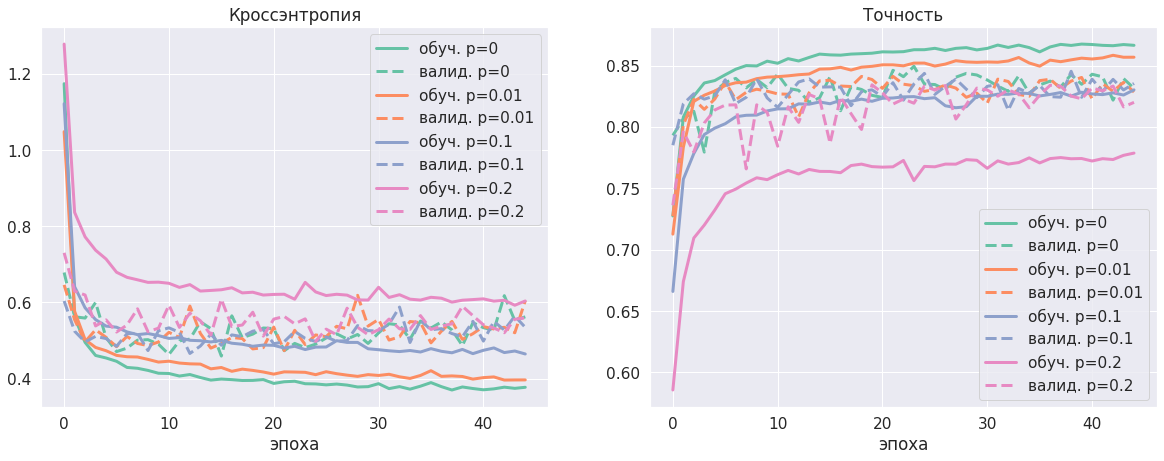

In [74]:
plot_histories(model_history, ['p=0', 'p=0.01', 'p=0.1', 'p=0.2'], colors=colors[:4])

С помощью Dropout получилось уменьшить переобучение, но при этом чем больше параметр p, тем хуже модель избавлялась от переобучения. Модель с Dropout обучалась немного дольше, чем без него (208 и 196 секунд соответственно).

### 4. Регуляризация весов
Проверьте распределение весов переобученной модели в пункте 3. Попробуйте добиться такого эффекта переобучения, при котором возникают большие значения некоторых весов. Даже если не получится, нужно показать, что вы пытались ;) 

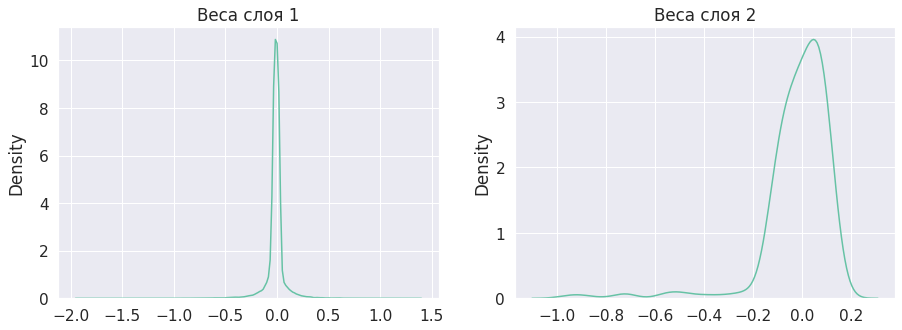

In [88]:
w1 = model[0].weight.detach().ravel().cpu()
w2 = model[2].weight.detach().ravel().cpu()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data=w1)
plt.title(f'Веса слоя 1')
plt.subplot(1, 2, 2)
sns.kdeplot(data=w2)
plt.title(f'Веса слоя 2');

In [80]:
w1.abs().max(), w2.abs().max()

(tensor(1.9182), tensor(0.9742))

Максимальные значения весов действительно получились довольно большими.

Примените L2-регуляризацию при обучении модели. Для этого нужно указать коэффициент регуляризации через параметр `weight_deacay` в оптимизаторе. При этом, если вы используете `Adam`, то его нужно поменять на `AdamW`, так как в `Adam` регуляризация реализована не совсем корректно. Покажите, что проблема больших весов решается.

In [95]:
model_reg = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.025)
history_2 = train(
                  model, 
                  criterion,
                  optimizer, 
                  train_loader,
                  test_loader,
                  num_epochs=45, 
                  device=device
)

Epoch 45 of 45. Total time 187.250s
  training loss (in-iteration): 	0.370106
  validation loss (in-iteration): 	0.520969
  training accuracy: 			86.76 %
  validation accuracy: 			83.48 %


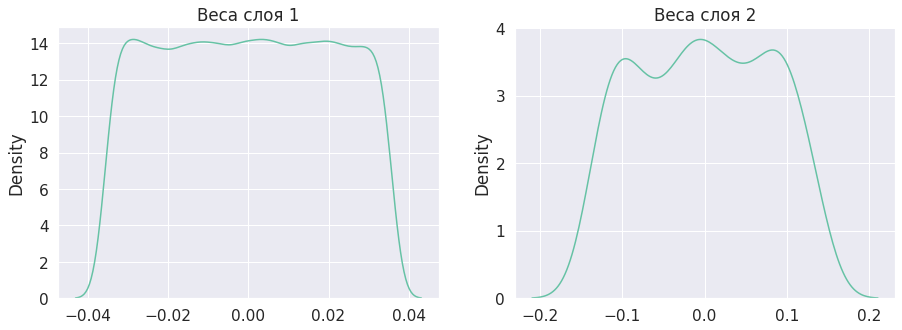

In [98]:
w1 = model_reg[0].weight.detach().ravel().cpu()
w2 = model_reg[2].weight.detach().ravel().cpu()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data=w1)
plt.title(f'Веса слоя 1')
plt.subplot(1, 2, 2)
sns.kdeplot(data=w2)
plt.title(f'Веса слоя 2');

In [99]:
w1.abs().max(), w2.abs().max()

(tensor(0.0357), tensor(0.1412))

При помощи регуляризации у нас получилось сделать так, чтобы диапазон значений, который принимают веса уменьшился, а соответственно переобучение стало меньше.

### 5. Затухание градиента

Продемонстрируйте эффект затухания градиента. Для этого постройте более глубокую сеть, в качестве функций активации используйте гиперболический тангенс. Визуализируйте долю градиентов близких к нулю на каждом слое в течение обучения. 

Попробуйте решить задачу затухания градиента двумя способами, предложенными на лекции.

### Выводы
Обобщите результаты проведенных экспериментов.

В первой задаче двухслойной сетью у нас получилось добиться очень хорошей точности на валидации (88%).  
Во второй мы исследовали точность модели в зависимости от места применения нормализации. Получилось, что лучше использовать BatchNorm перед функцией активации ReLU.  
В третьей задаче с помощью Dropout, который случайно выключает нейроны, получилось уменьшить эффект переобучения.  
В четвертой задаче с помощью регуляризации весов получилось уменьшить диапазон их значений при переобучении и тем самым уменьшить эффект переобучения.